In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
##############################################
# original code
#     with open(file, 'r') as inf:
#         lines = inf.read().splitlines()
##############################################
    lines = file
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# HPP

In [5]:
df_hpp = pd.read_csv('data/HPP.csv')

In [6]:
print('Loading model...')
model_2_1D = keras.models.load_model('Model_original_DeepMSpeptide.h5')

print('Loading input peptides')
# predict_data, skipped,  lines = load_pep_and_codify(args.infile[0], 81)
file = df_hpp.peptide.values
predict_data, skipped,  lines = load_pep_and_codify(file, 81)
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

print('Making predictions')
model_2_1D_pred = model_2_1D.predict(predict_data)
model_2_1D_pred = np.hstack((np.array(lines).reshape(len(lines), 1),model_2_1D_pred)).tolist()

Loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loading input peptides
Succesfully loaded 23273 peptides and skipped 0
Making predictions


In [7]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(model_2_1D_pred, columns=['peptide', 'probs'])['probs']], axis=1)
pe = df_hpp.loc[df_hpp.Class=='PE1'][['peptide', 'probs']].drop_duplicates()
dmp = df_hpp.loc[df_hpp.Class=='Detected_MPs'][['peptide', 'probs']].drop_duplicates()
mp = df_hpp.loc[df_hpp.Class=='MPs'][['peptide', 'probs']].drop_duplicates()

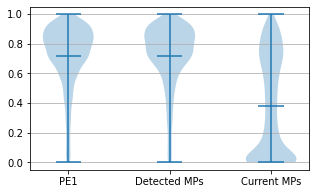

In [8]:
plt.figure(figsize=(5,3))
a = plt.violinplot([list(map(lambda x: 1-x, pe.probs.astype(float))), 
                    list(map(lambda x: 1-x, dmp.probs.astype(float))), 
                    list(map(lambda x: 1-x, mp.probs.astype(float)))],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

# massIVE-KB

In [9]:
df_test = pd.read_csv('data/test_diff_hpp.csv')[['peptide', 'label']].drop_duplicates()

In [11]:
print('Loading model...')
model_2_1D_retrained = keras.models.load_model('log/DeepMspeptide.h5')

Loading model...


In [12]:
print('Loading input peptides')
file = df_test.peptide.values
X_test, skipped,  lines = load_pep_and_codify(file, 81)
y_test = df_test.label.values
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

Loading input peptides
Succesfully loaded 170120 peptides and skipped 0


In [ ]:
probs = model_2_1D_retrained.predict(X_test)
y_pred = [1 if i>=0.5 else 0 for i in probs]
acc = model_2_1D_retrained.evaluate(X_test, y_test)

Test Accuracy: [0.40882030606353925, 0.81645894, 0.4088199]
Test AUC : 0.8973313748933661
              precision    recall  f1-score   support

       False     0.8128    0.8285    0.8206     86178
        True     0.8203    0.8041    0.8122     83942

    accuracy                         0.8165    170120
   macro avg     0.8166    0.8163    0.8164    170120
weighted avg     0.8165    0.8165    0.8164    170120



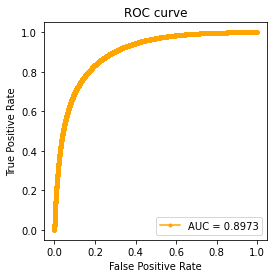

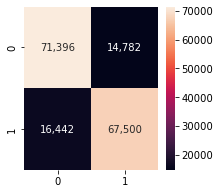

In [20]:
auc = roc_auc_score(y_test, probs)
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [21]:
np.save('log/result_DeepMSpeptide_fpr.npy', fpr)
np.save('log/result_DeepMSpeptide_tpr.npy', tpr)